In [ ]:
from google.cloud import vision
from google.cloud.vision_v1 import types
from PIL import Image, ImageDraw
import io

def detect_and_save_objects(image_path, output_dir):
    # Instantiates a client
    client = vision.ImageAnnotatorClient()

    # Loads the image into memory
    with io.open(image_path, 'rb') as image_file:
        content = image_file.read()

    # Construct an image instance
    image = vision.Image(content=content)

    # Perform object detection on the image file
    response = client.object_localization(image=image)
    objects = response.localized_object_annotations
    
 

    # Perform label detection on the image file
    response = client.label_detection(image=image)
    labels = response.label_annotations
    
    print(labels)
    
    print(objects)
    if response.error.message:
        raise Exception(f'Error: {response.error.message}')

    # Open the image using Pillow
    img = Image.open(image_path)

    # Process each detected object
    for i, obj in enumerate(objects):
        # Get the coordinates of the bounding box
        vertices = [(vertex.x * img.width, vertex.y * img.height) for vertex in obj.bounding_poly.normalized_vertices]
        
        # Define the bounding box (left, upper, right, lower)
        left = min([v[0] for v in vertices])
        upper = min([v[1] for v in vertices])
        right = max([v[0] for v in vertices])
        lower = max([v[1] for v in vertices])

        # Crop the object from the image using the bounding box
        cropped_obj = img.crop((left, upper, right, lower))
    
        # Save the cropped object as a new image
        output_image_path = f"{output_dir}/object_{i+1}_{obj.name}.jpeg"
        print(output_image_path)
        cropped_obj.save(output_image_path)
        print(f"Object '{obj.name}' saved as: {output_image_path}")

# Example usage
image_path = 'data/322879a99be84deedc5d77b59a1e3b85cf13b876111.jpeg'  # Replace with your image path
output_image_path = 'data/detected/'  # The path to save the output image
detect_and_save_objects(image_path, output_image_path)

In [ ]:
!pip install opencv-python ultralytics 


In [ ]:
import cv2
from ultralytics import YOLO
# Function to get class colors
def getColours(cls_num):
    base_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]
    color_index = cls_num % len(base_colors)
    increments = [(1, -2, 1), (-2, 1, -1), (1, -1, 2)]
    color = [base_colors[color_index][i] + increments[color_index][i] * 
    (cls_num // len(base_colors)) % 256 for i in range(3)]
    return tuple(color)

In [ ]:
def predict(chosen_model, img, classes=[], conf=0.5):
    if classes:
        results = chosen_model.predict(img, classes=classes, conf=conf)
    else:
        results = chosen_model.predict(img, conf=conf)

    return results


def predict_and_detect(chosen_model, img, classes=[], conf=0.5):
    results = predict(chosen_model, img, classes, conf=conf)

    for result in results:
        for box in result.boxes:
            cv2.rectangle(img, (int(box.xyxy[0][0]), int(box.xyxy[0][1])),
                          (int(box.xyxy[0][2]), int(box.xyxy[0][3])), (255, 0, 0), 2)
            cv2.putText(img, f"{result.names[int(box.cls[0])]}",
                        (int(box.xyxy[0][0]), int(box.xyxy[0][1]) - 10),
                        cv2.FONT_HERSHEY_PLAIN, 1, (255, 0, 0), 1)
    return img, results

model = YOLO("yolov8n.pt")
# read the image
image_path = 'data/322879a99be84deedc5d77b59a1e3b85cf13b876111.jpeg'
image = cv2.imread(image_path)

result_img = predict_and_detect(model, image, classes=[], conf=0.5)

In [ ]:
! wget "https://pjreddie.com/media/files/yolov3.weights"


In [ ]:
!pip install protobuf==3.20.3 --upgrade


In [ ]:
!pip install mediapipe  

In [ ]:
!wget -q -O efficientdet.tflite -q https://storage.googleapis.com/mediapipe-models/object_detector/efficientdet_lite0/int8/1/efficientdet_lite0.tflite

In [ ]:
#@markdown We implemented some functions to visualize the object detection results. <br/> Run the following cell to activate the functions.
import cv2
import numpy as np

MARGIN = 10  # pixels
ROW_SIZE = 10  # pixels
FONT_SIZE = 1
FONT_THICKNESS = 1
TEXT_COLOR = (255, 0, 0)  # red


def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for detection in detection_result.detections:
    # Draw bounding_box
    bbox = detection.bounding_box
    start_point = bbox.origin_x, bbox.origin_y
    end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height
    cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    probability = round(category.score, 2)
    result_text = category_name + ' (' + str(probability) + ')'
    text_location = (MARGIN + bbox.origin_x,
                     MARGIN + ROW_SIZE + bbox.origin_y)
    cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image

In [ ]:

IMAGE_FILE =  'data/322879a99be84deedc5d77b59a1e3b85cf13b876111.jpeg'

import cv2

img = cv2.imread(IMAGE_FILE)


In [ ]:
# STEP 1: Import the necessary modules.
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an ObjectDetector object.
base_options = python.BaseOptions(model_asset_path='efficientdet.tflite')
options = vision.ObjectDetectorOptions(base_options=base_options,
                                       score_threshold=0.5)
detector = vision.ObjectDetector.create_from_options(options)

# STEP 3: Load the input image.
image = mp.Image.create_from_file(IMAGE_FILE)

# STEP 4: Detect objects in the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result. In this case, visualize it.
image_copy = np.copy(image.numpy_view())
annotated_image = visualize(image_copy, detection_result)
rgb_annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)
cv2_imshow(rgb_annotated_image)

In [ ]:
!pip install protobuf==3.19.4

In [ ]:
! python -m pip install mediapipe

In [14]:
from google.cloud import vision
from google.cloud import storage
import cv2
import numpy as np
from google.cloud.vision_v1 import types

# Initialize the Vision API client
client = vision.ImageAnnotatorClient()

# Function to download image as bytes from GCS
def download_image_from_gcs(bucket_name, image_name):
    """Download image from Google Cloud Storage as bytes."""
    # Initialize GCS client
    storage_client = storage.Client()
    bucket = storage_client.get_bucket(bucket_name)
    blob = bucket.blob(image_name)
    
    # Download the image as a byte stream
    image_data = blob.download_as_bytes()
    
    return image_data

# Function to detect objects in the image
def detect_objects(image_data):
    """Detect objects in the image using the Vision API."""
    # Create an Image object using the image byte data
    image = vision.Image(content=image_data)
    
    # Call the Vision API to detect objects
    response = client.object_localization(image=image)

    # Check if the API call was successful
    if response.error.message:
        print(f"Error: {response.error.message}")
        return []

    objects = []

    # Iterate through the detected objects
    for object_ in response.localized_object_annotations:
        print(f"Object name: {object_.name}")
        print(f"Confidence: {object_.score}")
        print(f"Bounding box: {object_.bounding_poly}")
        
        # Append object details to the list
        objects.append({
            'name': object_.name,
            'score': object_.score,
            'bounding_box': object_.bounding_poly
        })
    
    return objects

# Function to draw bounding boxes on the image
def draw_bounding_boxes(image_data, objects):
    """Draw bounding boxes on the image."""
    # Convert image byte data to numpy array (OpenCV format)
    nparr = np.frombuffer(image_data, np.uint8)
    image = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    
    # Iterate through each object and draw bounding boxes
    for obj in objects:
        bbox = obj['bounding_box']
        
        # Get coordinates of the bounding box
        vertices = []
        for vertex in bbox.normalized_vertices:
            x = int(vertex.x * image.shape[1])
            y = int(vertex.y * image.shape[0])
            vertices.append((x, y))
        
        # Draw rectangle around the detected object
        cv2.polylines(image, [np.array(vertices, np.int32)], isClosed=True, color=(255, 0, 0), thickness=2)
        
        # Add text label for the object
        label = f"{obj['name']} ({obj['score']*100:.2f}%)"
        cv2.putText(image, label, (vertices[0][0], vertices[0][1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
    
    return image

# Function to save image with bounding boxes
def save_image(image, output_file):
    """Save the image with bounding boxes to a file."""
    cv2.imwrite(output_file, image)
    print(f"Image with bounding boxes saved to {output_file}")

# Example usage
bucket_name = 'nineshowcaseassets'
image_name = 'IMAGES_00f3be32c0f5355f0ba0f5bbeb1a298b95e82214.jpeg'

# Download image from GCS
image_data = download_image_from_gcs(bucket_name, image_name)

# Detect objects in the image
objects = detect_objects(image_data)

# Draw bounding boxes on the image
image_with_boxes = draw_bounding_boxes(image_data, objects)

# Save the image with bounding boxes
output_file = 'output_image_with_bboxes.jpg'
save_image(image_with_boxes, output_file)


Object name: 1D barcode
Confidence: 0.7415566444396973
Bounding box: normalized_vertices {
  x: 0.0688476562
  y: 0.75
}
normalized_vertices {
  x: 0.204101562
  y: 0.75
}
normalized_vertices {
  x: 0.204101562
  y: 0.83203125
}
normalized_vertices {
  x: 0.0688476562
  y: 0.83203125
}

Image with bounding boxes saved to output_image_with_bboxes.jpg


In [23]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load a pre-trained Faster R-CNN model (ResNet50 backbone)
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# Set the model to evaluation mode
model.eval()

# Load the image to detect objects in
image_path = 'data/322879a99be84deedc5d77b59a1e3b85cf13b876111.jpeg'
image = Image.open(image_path)

# Apply the necessary transformations (resize, normalization, etc.)
transform = transforms.Compose([
    transforms.ToTensor(),
])

image_tensor = transform(image).unsqueeze(0)  # Add batch dimension


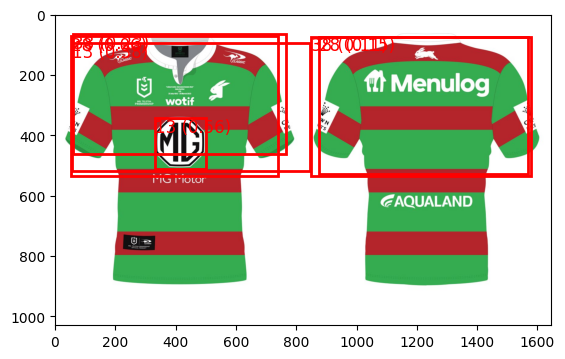

In [24]:
# Make predictions
with torch.no_grad():  # Disable gradient calculation (since we are in inference mode)
    prediction = model(image_tensor)

# Extract bounding boxes and labels
boxes = prediction[0]['boxes'].cpu().numpy()
labels = prediction[0]['labels'].cpu().numpy()
scores = prediction[0]['scores'].cpu().numpy()

# Set a confidence threshold to filter predictions
confidence_threshold = 0.0
filtered_boxes = boxes[scores >= confidence_threshold]
filtered_labels = labels[scores >= confidence_threshold]
filtered_scores = scores[scores >= confidence_threshold]

# Visualize the results
plt.imshow(image)
ax = plt.gca()

# Draw bounding boxes
for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
    x1, y1, x2, y2 = box
    ax.add_patch(plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, color='r', linewidth=2))
    ax.text(x1, y1, f"{label} ({score:.2f})", color='r', fontsize=12, verticalalignment='top')

plt.show()


In [ ]:
from ultralytics import YOLO
import cv2

# Load the pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')  # You can also use other versions like 'yolov8m.pt', 'yolov8l.pt', 'yolov8x.pt'

# Read an image for detection (replace with your own image path)
image_path = 'data/322879a99be84deedc5d77b59a1e3b85cf13b876111.jpeg'
image = cv2.imread(image_path)


# Run the object detection
results = model(image)
print(results)
# Extract the boxes, labels, and scores
boxes = results[0].boxes.xyxy.cpu().numpy()  # Bounding box coordinates (xyxy format)
labels = results[0].names  # Class names of detected objects
scores = results[0].boxes.conf.cpu().numpy()  # Confidence scores of each detection
print('****')
# Loop through the results and draw the bounding boxes
for box, score in zip(boxes, scores):
    x1, y1, x2, y2 = box
    class_id = int(box[4])  # This is for the class ID in YOLO output
    label = labels[class_id]  # Get the class name using the class ID
    
    # Draw the bounding box
    cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
    
    # Display label and confidence score
    cv2.putText(image, f"{label} {score:.2f}", 
                (int(x1), int(y1) - 10), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

# Show the image with the bounding boxes
cv2.imshow('Detection Results', image)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Optionally save the output image with bounding boxes
cv2.imwrite('output_image_with_boxes.jpg', image)



0: 416x640 (no detections), 721.2ms
Speed: 172.0ms preprocess, 721.2ms inference, 1260.9ms postprocess per image at shape (1, 3, 416, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 4